In [1]:
import os
os.chdir('/root/')

In [2]:
# cloning SG toolkit
if os.path.isdir('jSGG')==False:
    !git clone https://github.com/jaleedkhan/jSGG
os.chdir('jSGG')

In [3]:
# downloading pretrained models
import boto3
if os.path.isdir('upload_causal_motif_sgdet'):
    print("'jSGG/upload_causal_motif_sgdet' already exists")
else:
    #!wget -O ucms.zip "https://onedrive.live.com/download?cid=22376FFAD72C4B64&resid=22376FFAD72C4B64%21781947&authkey=AF_EM-rkbMyT3gs"
    boto3.Session().resource('s3').Bucket('jaleed-bucket').download_file('upload_causal_motif_sgdet.zip','upload_causal_motif_sgdet.zip')
    !unzip upload_causal_motif_sgdet.zip -d upload_causal_motif_sgdet/

'jSGG/upload_causal_motif_sgdet' already exists


In [4]:
# dependencies
!python -m pip install ipython
!python -m pip install scipy
!python -m pip install h5py
!python -m pip install ninja yacs cython matplotlib tqdm opencv-python overrides
!python -m pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install --upgrade setuptools

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [5]:
# installing cocoapi (not from https://github.com/cocodataset/cocoapi.git)
if os.path.isdir('cocoapi') == False:
    !git clone https://github.com/philferriere/cocoapi.git
%cd cocoapi/PythonAPI
!make
!make install
!python setup.py install
%cd ../..

/root/jSGG/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
rm -rf build
# install pycocotools to the Python site-packages
python setup.py build_ext install
running build_ext
building 'pycocotools._mask' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
creating build/common
gcc -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -I/opt/conda/lib/python3.6/site-packages/numpy/core/include -I../common -I/opt/conda/include/python3.6m -c pycocotools/_mask.c -o build/temp.linux-x86_64-3.6/pycocotools/_mask.o
In file included from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822:0,
                 from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.6/site-packages/numpy/core/include/numpy/arrayobject.h:4,
              

In [6]:
# installing apex
if os.path.isdir('apex') == False:
    !git clone https://github.com/NVIDIA/apex.git
%cd apex
!python setup.py install #--cuda_ext --cpp_ext
%cd ..

/root/jSGG/apex


torch.__version__  = 1.9.0+cu102


setup.py:67: UserWarning: Option --pyprof not specified. Not installing PyProf dependencies!
  warnings.warn("Option --pyprof not specified. Not installing PyProf dependencies!")
running install
running bdist_egg
running egg_info
writing apex.egg-info/PKG-INFO
writing dependency_links to apex.egg-info/dependency_links.txt
writing top-level names to apex.egg-info/top_level.txt
reading manifest file 'apex.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'apex.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py

creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/apex
creating build/bdist.linux-x86_64/egg/apex/pyprof
creating build/bdist.linux-x86_64/egg/apex/pyprof/nvtx
copying build/lib/apex/pyprof/nvtx/nvmarker.py -> build/bdist.linux-x86_64/egg/apex/pyprof/nvtx
copying build/lib/apex/pyprof/nvtx/__init__.py -> build/bdist.

In [7]:
try:
    from apex import amp
except ImportError:
    raise ImportError('Use APEX for mixed precision via apex.amp')

In [8]:
# Installing the actual SGG library
!python setup.py build develop

running build
running build_py
copying maskrcnn_benchmark/config/paths_catalog_2.py -> build/lib.linux-x86_64-3.6/maskrcnn_benchmark/config

running build_ext
building 'maskrcnn_benchmark._C' extension
Emitting ninja build file /root/jSGG/build/temp.linux-x86_64-3.6/build.ninja...
Compiling objects...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/11] c++ -MMD -MF /root/jSGG/build/temp.linux-x86_64-3.6/root/jSGG/maskrcnn_benchmark/csrc/cpu/ROIAlign_cpu.o.d -pthread -B /opt/conda/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -DWITH_CUDA -I/root/jSGG/maskrcnn_benchmark/csrc -I/opt/conda/lib/python3.6/site-packages/torch/include -I/opt/conda/lib/python3.6/site-packages/torch/include/torch/csrc/api/include -I/opt/conda/lib/python3.6/site-packages/torch/include/TH -I/opt/conda/lib/python3.6/site-packages/torch/include/THC -I/usr/local/cuda/include -I/opt/conda/inclu

In [9]:
import argparse
import os
from PIL import Image
import json
import torch
from tqdm import tqdm_notebook # module for tracking the training process

In [10]:
# Importing local dependencies
from maskrcnn_benchmark.utils.env import setup_environment
from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.data_2 import make_data_loader
from maskrcnn_benchmark.engine_2.inference import inference
from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.utils.collect_env import collect_env_info
from maskrcnn_benchmark.utils.comm import synchronize, get_rank
from maskrcnn_benchmark.utils.logger import setup_logger
from maskrcnn_benchmark.utils.miscellaneous import mkdir

In [11]:
!cp config.yml upload_causal_motif_sgdet/config.yml
!cp last_checkpoint upload_causal_motif_sgdet/last_checkpoint
!mkdir glove
!mkdir checkpoints
!mkdir checkpoints/custom_images
!mkdir checkpoints/your_output_path

mkdir: cannot create directory ‘glove’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
mkdir: cannot create directory ‘checkpoints/custom_images’: File exists
mkdir: cannot create directory ‘checkpoints/your_output_path’: File exists


In [12]:
def im2scenegraph(tst_img, MPDC):
    # CUSTOMIZABLES FOR RUNNING AN SGG

    # The Glove Directory Path
    GD = 'glove/'

    # Pretrained Model Path
    #MPDC = 'D:\\Downloads\\upload_causal_motif_sgdet'

    # Output Directory if default VGG dataset is used
    OD = 'upload_causal_motif_sgdet/'

    # If evaluation should be done on custom images, set this 'True'
    TCE = 'True'

    # The path for custom images for SGG detection, if TEST.CUSTUM_EVAL is 'True'
    TCP = 'checkpoints/custom_images'

    # The path for output of SGG for custom images, if TEST.CUSTUM_EVAL is 'True'
    DSD = 'checkpoints/your_output_path'

    configuration_file = "configs/e2e_relation_X_101_32_8_FPN_1x.yaml"
    option_txt = ['MODEL.ROI_RELATION_HEAD.USE_GT_BOX', 'False', 'MODEL.ROI_RELATION_HEAD.USE_GT_OBJECT_LABEL', 'False',
    'MODEL.ROI_RELATION_HEAD.PREDICTOR', 'CausalAnalysisPredictor', 'MODEL.ROI_RELATION_HEAD.CAUSAL.EFFECT_TYPE', 'TDE',
    'MODEL.ROI_RELATION_HEAD.CAUSAL.FUSION_TYPE', 'sum', 'MODEL.ROI_RELATION_HEAD.CAUSAL.CONTEXT_LAYER', 'motifs',
    'TEST.IMS_PER_BATCH', '1', 'DTYPE', 'float16', 'GLOVE_DIR', GD, 'MODEL.PRETRAINED_DETECTOR_CKPT', MPDC,
    'OUTPUT_DIR', OD, 'TEST.CUSTUM_EVAL', TCE, 'TEST.CUSTUM_PATH', TCP, 'DETECTED_SGG_DIR', DSD]
    parser = argparse.ArgumentParser(description="PyTorch Object Detection Inference")
    parser.add_argument(
        "--config-file",
        default="/private/home/fmassa/github/detectron.pytorch_v2/configs/e2e_faster_rcnn_R_50_C4_1x_caffe2.yaml",
        metavar="FILE",
        help="path to config file",
    )
    parser.add_argument("--local_rank", type=int, default=0)
    parser.add_argument(
        "opts",
        help="Modify config options using the command-line",
        default=None,
        nargs=argparse.REMAINDER,
    )

    args = parser.parse_args(args=[])

    num_gpus = int(os.environ["WORLD_SIZE"]) if "WORLD_SIZE" in os.environ else 1
    distributed = num_gpus > 1

    if distributed:
        torch.cuda.set_device(args.local_rank)
        torch.distributed.init_process_group(
            backend="nccl", init_method="env://"
        )
        synchronize()

    cfg.merge_from_file(configuration_file)
    cfg.merge_from_list(option_txt)
    #print("Merging from list:")
    #print(args.opts)
    #cfg.merge_from_file(args.config_file)
    #cfg.merge_from_list(args.opts)
    cfg.freeze()

    save_dir = ""
    logger = setup_logger("maskrcnn_benchmark", save_dir, get_rank())
    logger.info("Using {} GPUs".format(num_gpus))
    logger.info(cfg)

    logger.info("Collecting env info (might take some time)")
    logger.info("\n" + collect_env_info())

    model = build_detection_model(cfg)
    model.to(cfg.MODEL.DEVICE)

    # Initialize mixed-precision if necessary
    use_mixed_precision = cfg.DTYPE == 'float16'
    amp_handle = amp.init(enabled=use_mixed_precision, verbose=cfg.AMP_VERBOSE)

    output_dir = cfg.OUTPUT_DIR
    print("ESP - Output Dir: ", output_dir)
    #print("Printing CFG: \n", cfg)
    #print("Printing Model: \n", model)
    checkpointer = DetectronCheckpointer(cfg, model, save_dir=output_dir)
    print("cfg.MODEL.WEIGHT: ", cfg.MODEL.WEIGHT)
    _ = checkpointer.load(cfg.MODEL.WEIGHT)

    iou_types = ("bbox",)
    if cfg.MODEL.MASK_ON:
        iou_types = iou_types + ("segm",)
    if cfg.MODEL.KEYPOINT_ON:
        iou_types = iou_types + ("keypoints",)
    if cfg.MODEL.RELATION_ON:
        iou_types = iou_types + ("relations", )
    if cfg.MODEL.ATTRIBUTE_ON:
        iou_types = iou_types + ("attributes", )
    output_folders = [None] * len(cfg.DATASETS.TEST)
    dataset_names = cfg.DATASETS.TEST
    if cfg.OUTPUT_DIR:
        for idx, dataset_name in enumerate(dataset_names):
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
            mkdir(output_folder)
            output_folders[idx] = output_folder

    #tst_img = Image.open('tools/horse.jpg').convert("RGB")
    data_loaders_val, custom_data_info = make_data_loader(cfg, tst_img, mode="test", is_distributed=distributed)
    for output_folder, dataset_name, data_loader_val in zip(output_folders, dataset_names, data_loaders_val):
        custom_prediction = inference(
            cfg,
            model,
            data_loader_val,
            dataset_name=dataset_name,
            iou_types=iou_types,
            box_only=False if cfg.MODEL.RETINANET_ON else cfg.MODEL.RPN_ONLY,
            device=cfg.MODEL.DEVICE,
            expected_results=cfg.TEST.EXPECTED_RESULTS,
            expected_results_sigma_tol=cfg.TEST.EXPECTED_RESULTS_SIGMA_TOL,
            output_folder=output_folder,
        )
        synchronize()
        output_dict = {
            'custom_data_info': custom_data_info,
            'custom_prediction': custom_prediction
        }
        #cd ..
        return output_dict

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [14]:
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

In [15]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    #size = np.array(get_size(pic.size))
    #print(size)
    #lol = size/100
    #lol[0] = int(lol[0])
    #lol[1] = int(lol[1])
    #print(lol)
    #x1 = x1 * lol[0]
    #x2 = x2 * lol[0]
    #y1 = y1 * lol[1]
    #y2 = y2 * lol[1]
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)
        
def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))
    
def draw_image(pic, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    orig_size = pic.size
    size = get_size(orig_size)
    pic_r = pic.resize(size)
    print('orig_size = '+str(orig_size))
    print('size = '+str(size))
    #print('boxes = '+str(boxes))
    #num_obj = len(boxes)
    #for i in range(num_obj):
    #    info = str(i) + '_' + box_labels[i]
    #    draw_single_box(pic, boxes[i], draw_info=info)
    display(pic_r)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)
    
    return None

def get_size(image_size):
    min_size = 300
    max_size = 500
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

In [16]:
from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

#f = fs.open(f'https://cs.stanford.edu/people/rak248/VG_100K/2370463.jpg')
#f = fs.open(f's3://jaleed-bucket/vg/images/2316655.jpg')
f = fs.open(f's3://jaleed-bucket/vg/images/2317213.jpg')
image = Image.open(f)
pretrained_model_path = 'upload_causal_motif_sgdet/'
output = im2scenegraph(image, pretrained_model_path)

# load the following to files from DETECTED_SGG_DIR
custom_prediction = output['custom_prediction']
custom_data_info = output['custom_data_info']

2021-09-04 17:19:49,768 maskrcnn_benchmark INFO: Using 1 GPUs
2021-09-04 17:19:49,769 maskrcnn_benchmark INFO: AMP_VERBOSE: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  NUM_WORKERS: 1
  SIZE_DIVISIBILITY: 5
DATASETS:
  TEST: ('VG_stanford_filtered_with_attribute_test',)
  TRAIN: ('VG_stanford_filtered_with_attribute_train',)
  VAL: ('VG_stanford_filtered_with_attribute_val',)
DETECTED_SGG_DIR: checkpoints/your_output_path
DTYPE: float16
GLOVE_DIR: glove/
INPUT:
  BRIGHTNESS: 0.0
  CONTRAST: 0.0
  HUE: 0.0
  MAX_SIZE_TEST: 100
  MAX_SIZE_TRAIN: 100
  MIN_SIZE_TEST: 100
  MIN_SIZE_TRAIN: (100,)
  PIXEL_MEAN: [102.9801, 115.9465, 122.7717]
  PIXEL_STD: [1.0, 1.0, 1.0]
  SATURATION: 0.0
  TO_BGR255: True
  VERTICAL_FLIP_PROB_TRAIN: 0.0
MODEL:
  ATTRIBUTE_ON: False
  BACKBONE:
    CONV_BODY: R-101-FPN
    FREEZE_CONV_BODY_AT: 2
  CLS_AGNOSTIC_BBOX_REG: False
  DEVICE: cuda
  FBNET:
    ARCH: default
    ARCH_DEF: 
    BN_TYPE: bn
    DET_HEAD_BLOCKS: []
    DET_HEAD_LAST_SCALE: 1.0
   

  0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

2021-09-04 17:20:04,797 maskrcnn_benchmark.inference INFO: Total run time: 0:00:00.388981 (0.3889811038970947 s / img per device, on 1 devices)
2021-09-04 17:20:04,798 maskrcnn_benchmark.inference INFO: Model inference time: 0:00:00.280541 (0.28054141998291016 s / img per device, on 1 devices)


=====> checkpoints/your_output_path/custom_prediction.json SAVED !


orig_size = (500, 380)
size = (394, 300)


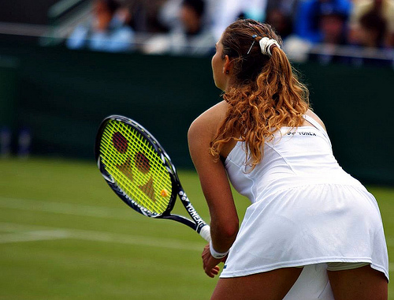

**************************************************
box_labels 0: woman; score: 0.7024610042572021
box_labels 1: person; score: 0.12633462250232697
box_labels 2: people; score: 0.05803395435214043
box_labels 3: shirt; score: 0.056940753012895584
box_labels 4: racket; score: 0.03883880376815796
box_labels 5: hair; score: 0.03631117194890976
**************************************************
rel_labels 0: 0_woman => wearing => 3_shirt; score: 0.6306355595588684
rel_labels 1: 1_person => wearing => 3_shirt; score: 0.6299739480018616
rel_labels 2: 2_people => wearing => 3_shirt; score: 0.6221685409545898
rel_labels 3: 3_shirt => on => 0_woman; score: 0.5484416484832764
rel_labels 4: 2_people => with => 5_hair; score: 0.5186195373535156
rel_labels 5: 3_shirt => on => 1_person; score: 0.5090742707252502
rel_labels 6: 1_person => with => 5_hair; score: 0.4912315607070923
rel_labels 7: 0_woman => with => 5_hair; score: 0.4875468909740448
rel_labels 8: 0_woman => holding => 4_racket; score: 0.42

In [17]:
# Display results
image_idx = 0
box_topk = 6 # select top k bounding boxes
rel_topk = 20 # select top k relationships
ind_to_classes = custom_data_info['ind_to_classes']
ind_to_predicates = custom_data_info['ind_to_predicates']
boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

for i in range(len(box_labels)):
    box_labels[i] = ind_to_classes[box_labels[i]]

rel_labels = []
rel_scores = []
for i in range(len(all_rel_pairs)):
    if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
        rel_scores.append(all_rel_scores[i])
        label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
        rel_labels.append(label)

rel_labels = rel_labels[:rel_topk]
rel_scores = rel_scores[:rel_topk]

draw_image(image, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)